## Dependencies ##

In [0]:
# installs 
# torch, torchvision
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

!pip install tifffile 
!pip install scikit-image

In [0]:
# imports 
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim

import numpy as np 
from skimage import measure 
import tifffile 


import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
matplotlib.rcParams['axes.grid'] = False

In [0]:
# utils
def connected_components(boundaries):
    assert(len(boundaries.shape) == 3)
    boundaries = boundaries.astype(np.int64)
    ccs = np.zeros_like(boundaries)
    for z in range(ccs.shape[0]):
        ccs[z] = measure.label(boundaries[z])
        
    return ccs

def randomize_ids(segs, seed=None, lim=256):
    """Randomly change segment ids. Useful for visualization purposes"""
    np.random.seed(seed)
    
    segs = np.copy(segs).astype(np.int64)
    size = np.random.randint(lim,2*lim)
    remap = np.random.randint(1,lim+1,size)
    segs[segs != 0] = remap[segs[segs != 0] % size] # dont change 0s
    
    np.random.seed(None)

    return segs

In [0]:
# get data 
!wget https://github.com/cos485/data/raw/master/isbi2012/train-volume.tif
!wget https://github.com/cos485/data/raw/master/isbi2012/train-labels.tif

imgs = tifffile.imread('train-volume.tif').astype(np.float32)
imgs = imgs - np.mean(imgs, axis=(1,2)).reshape((-1,1,1)) # normalize inputs
imgs = imgs / (np.std(imgs, axis=(1,2)).reshape((-1,1,1)) + 1e-6)

bdys = tifffile.imread('train-labels.tif')
bdys = (bdys > 0).astype(np.float32)

segs = connected_components(bdys)


imgs_trn = imgs[:20]
bdys_trn = bdys[:20]
segs_trn = segs[:20]

imgs_val = imgs[20:]
bdys_val = bdys[20:]
segs_val = segs[20:]

print(imgs_trn.shape, imgs_val.shape)

--2019-01-26 22:21:20--  https://github.com/cos485/data/raw/master/isbi2012/train-volume.tif
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cos485/data/master/isbi2012/train-volume.tif [following]
--2019-01-26 22:21:21--  https://raw.githubusercontent.com/cos485/data/master/isbi2012/train-volume.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7870730 (7.5M) [application/octet-stream]
Saving to: ‘train-volume.tif’

train-volume.tif    100%[===================>]   7.51M  --.-KB/s    in 0.1s    

2019-01-26 22:21:21 (77.0 MB/s) - ‘train-volume.tif’ saved [7870730/7870730]

--201

## Visualize Data ##

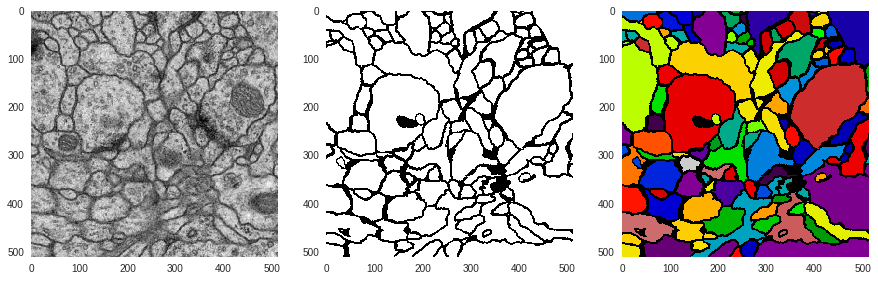

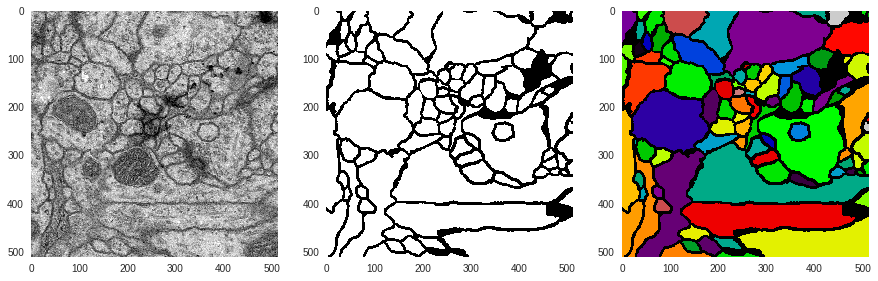

In [0]:
# visualize data 
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(imgs_trn[0], cmap='gray')
plt.subplot(132)
plt.imshow(bdys_trn[0], cmap='gray')
plt.subplot(133)
plt.imshow(randomize_ids(segs_trn[0]), cmap='nipy_spectral')
plt.grid(False)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(imgs_val[0], cmap='gray')
plt.subplot(132)
plt.imshow(bdys_val[0], cmap='gray')
plt.subplot(133)
plt.imshow(randomize_ids(segs_val[0]), cmap='nipy_spectral')
plt.show()

## Create UNet ##

In [0]:
# helper operations 
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x 
        
def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        ## Your code here ##

        self.layer1 = conv3x3(in_channels, out_channels)
        self.layer2 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()
        ## Your code here ##
        self.contract = maxpool2x2()
        self.layer1 = conv3x3(in_channels, out_channels)
        self.layer2 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = self.contract(x)
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()
        ## Your code here ##
        self.expand = UpConv2x2(in_channels)
        self.layer1 = conv3x3(in_channels, out_channels)
        self.layer2 = conv3x3(out_channels, out_channels)



    def forward(self, xh, xv):
        """
        Args:
            xh: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xv: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        ## Your code here ##
        xv = self.expand.forward(xv)
        x = concat(xh, xv)
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])

        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
        
        self.conv_out = conv3x3(fs[0], 1)

        self._initialize_weights()

    def forward(self, x):
        ## Your code here ##
        x = self.conv_in(x)
        
        sub_1 = self.dconv1(x)
        sub_2 = self.dconv2(sub_1)
        sub_3 = self.dconv3(sub_2)
        sub_4 = self.dconv4(sub_3)
        
        base_1 = self.uconv1(sub_3, sub_4)
        base_2 = self.uconv2(sub_2, base_1)
        base_3 = self.uconv3(sub_1, base_2)
        x = self.uconv4(x, base_3)
        
        
        x = self.conv_out(x)
        return x

    def _initialize_weights(self):
        conv_modules = [m for m in self.modules() if isinstance(m, nn.Conv2d)]
        for m in conv_modules:
            ## Your code here ##
            n = 2/(m.kernel_size[0] * m.kernel_size[1] * m.out_channels)
            m.weight.data.normal_(0.0, np.sqrt(n))


## Train UNet ##

In [0]:
# train utils
def np2var(arr, cuda):
    arr = np.expand_dims(np.expand_dims(arr, 0), 0)
    arr = torch.from_numpy(arr)
    arr = Variable(arr)
    if cuda:
        arr = arr.cuda()
    return arr

def var2np(arr):
    arr = arr.data.cpu().numpy()[0,0]
    return arr
    

In [0]:
# plot utils
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)

def plot(step, log_every, train_loss, val_loss, img_trn, img_val, pred_trn, pred_val, true_trn, true_val):
    clear_output(wait=False)
    plt.gcf().clear()
    
    plt.subplot(241)
    iters = np.arange(0,len(train_loss))*log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")

    plt.subplot(242)
    plt.imshow(img_trn, cmap='gray')
    plt.title("Input image, train")
    
    plt.subplot(243)
    plt.imshow(pred_trn, cmap='gray')
    plt.title("Predicted, train")
    
    
    plt.subplot(244)
    plt.imshow(true_trn, cmap='gray')
    plt.title("True, train")
    
    plt.subplot(246)
    plt.imshow(img_val, cmap='gray')
    plt.title("Input image, val")
    
    plt.subplot(247)
    plt.imshow(pred_val, cmap='gray')
    plt.title("Predicted, val")
    
    
    plt.subplot(248)
    plt.imshow(true_val, cmap='gray')
    plt.title("True, val")


    plt.gcf().set_size_inches(18, 7)
    display(plt.gcf())

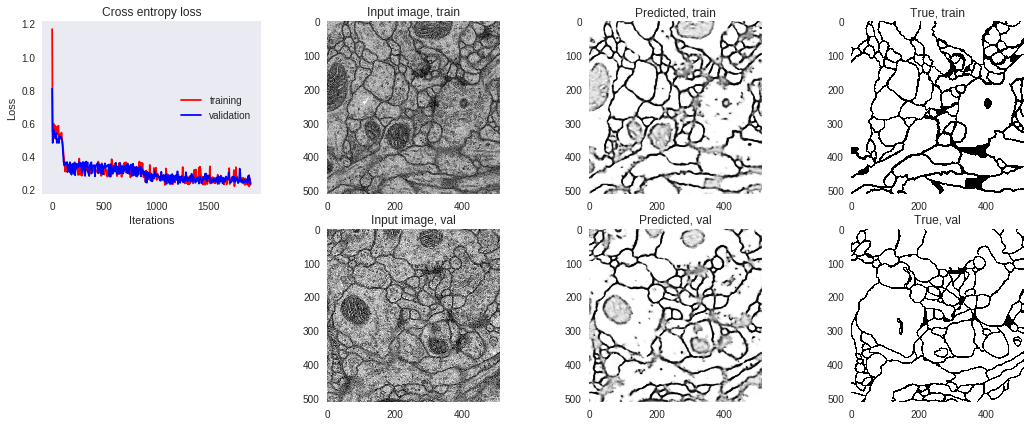

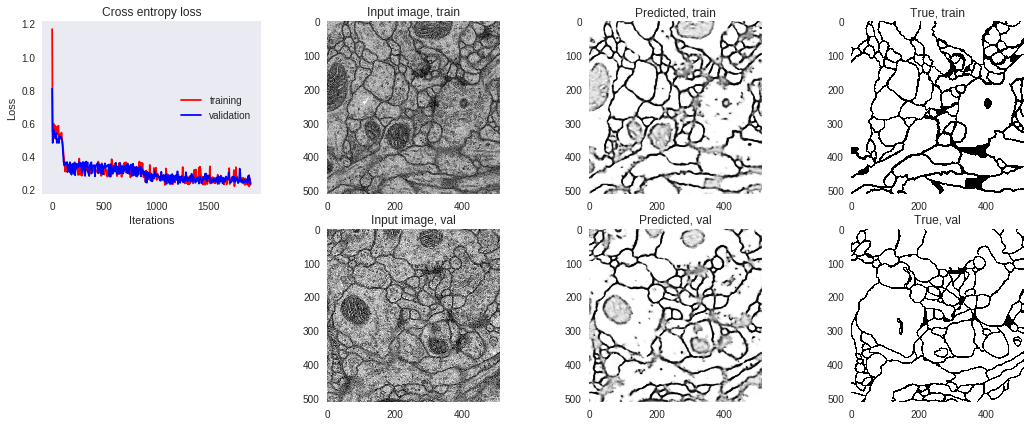

In [0]:
## Train network ##

# params
USECUDA = True
max_iter = 2000
log_every = 5
plot_every = 100
lr = 0.001

# create net
net = UNet()
if USECUDA:
    net.cuda()
    
# create optimizer 
optimizer = optim.Adam(net.parameters(), lr=lr)

# train net
losses_trn = []
losses_val = []
for t in range(max_iter):
    # choose sample
    idx = np.random.randint(0,imgs_trn.shape[0])
    img, bdy = imgs_trn[idx], bdys_trn[idx]
    
    # format
    img = np2var(img, cuda=USECUDA)
    bdy = np2var(bdy, cuda=USECUDA)
    
    # forward, backward, update
    optimizer.zero_grad()
    pred = net(img)
    loss = F.binary_cross_entropy_with_logits(pred, bdy)
    loss.backward()
    optimizer.step()
    

    # log stuff
    if t % log_every == 0: 
        # validation info
        idx = np.random.randint(0,imgs_val.shape[0])
        img_val, bdy_val = imgs_val[idx], bdys_val[idx]

        # format
        img_val = np2var(img_val, cuda=USECUDA)
        bdy_val = np2var(bdy_val, cuda=USECUDA)

        # forward
        pred_val = net(img_val)
        loss_val = F.binary_cross_entropy_with_logits(pred_val, bdy_val)

        # store
        losses_trn.append(loss.data[0])
        losses_val.append(loss_val.data[0])
        
    # plot stuff
    if t % plot_every == 0:
        plot(t, log_every, losses_trn, losses_val, 
             var2np(img), var2np(img_val),
             var2np(F.sigmoid(pred)), var2np(F.sigmoid(pred_val)),
             var2np(bdy), var2np(bdy_val))
    
    

In [0]:
# clear output after running
clear_output()

## Make Segmentations ##

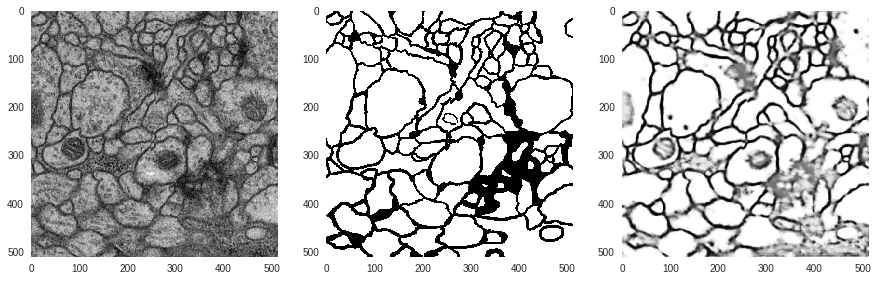

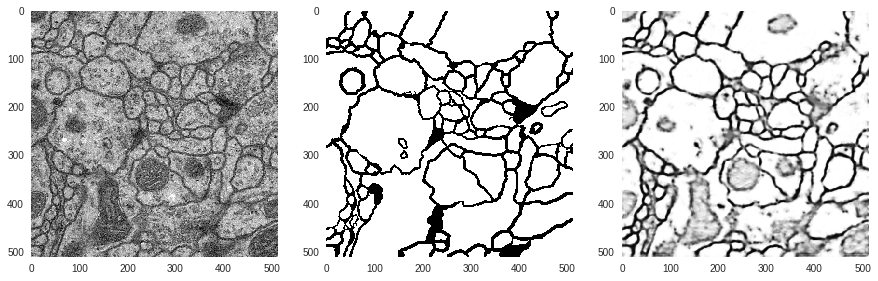

In [0]:
# inspect outputs
def plot_boundaries(im1, im2, im3):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(im1, cmap='gray')
    plt.subplot(132)
    plt.imshow(im2, cmap='gray')
    plt.subplot(133)
    plt.imshow(im3, cmap='gray')
    plt.show()
    

# training set 
img = imgs_trn[5]
true = bdys_trn[5]
pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA))))
plot_boundaries(img, true, pred)

# validation set
img = imgs_val[5]
true = bdys_val[5]
pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA))))
plot_boundaries(img, true, pred)

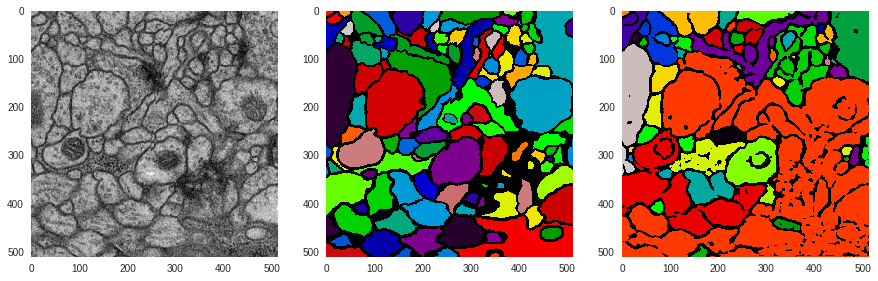

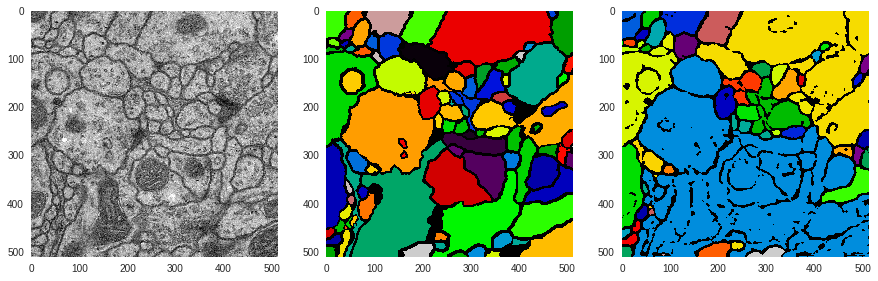

In [0]:
# analyze results
def plot_segmentations(im1, im2, im3):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(im1, cmap='gray')
    plt.subplot(132)
    plt.imshow(im2, cmap='nipy_spectral')
    plt.subplot(133)
    plt.imshow(im3, cmap='nipy_spectral')
    plt.show()
    
# training 
z = 5
img = imgs_trn[z]
bdy_true = bdys_trn[z]
bdy_pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA)))) > 0.5
seg_true = randomize_ids(segs_trn[z])
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(img, seg_true, seg_pred)

# validation 
z = 5
img = imgs_val[z]
bdy_true = bdys_val[z]
bdy_pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA)))) > 0.5
seg_true = randomize_ids(segs_val[z])
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(img, seg_true, seg_pred)